In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#sklearn tools
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.preprocessing import scale
from sklearn.metrics import roc_curve
from sklearn.metrics import auc


#Classifiers
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
sns.set()

%matplotlib inline

In [22]:
df_master = pd.read_pickle('GTD_df.p')

In [35]:
row_mask = ((df_master['doubtterr'] == 0) &   # exclude any doubt on terror
            (df_master['individual'] != 1))  # unaffiliated individuals

df_master = df_master[row_mask]
df_c = df_master.groupby(['country_txt', 'iyear', 'imonth']).agg({"nkill": 'sum', 'gname': 'nunique'})
#fill holes
new_index = pd.MultiIndex.from_product([df_c.index.get_level_values(0).unique(), np.arange(1973,2018), np.arange(1,13)])
df_c = df_c.reindex(new_index).fillna(0)
df_c = df_c.reset_index()
df_c.rename(columns={'level_0':'country',
                     'level_1': 'year',
                     'level_2': 'month'}, inplace=True)


#create lags
for n in range(1,13):
    new_column = 'nkill_AR'+str(n)
    df_c[new_column] = df_c.groupby(['country'])['nkill'].shift(n)

df_c['Attack'] = np.where(df_c['nkill']>0, 'Yes', 'No')
df_c.shape

(108540, 18)

In [26]:
# First attempt at modeling
train_mask1 = ((df_c['year'] > 2000) &
               (df_c['year'] < 2016))# focus on after 2000 and exclude test

test_mask1 = (df_c['year'] == 2016)
            
           
features1 = ['nkill_AR'+str(n) for n in range(1,13)]

labels1 = ['Attack']

#define X, y, train, and test
X1_train = df_c[features1][train_mask1]
X1_test = df_c[features1][test_mask1]
y1_train = df_c[labels1][train_mask1]
y1_test = df_c[labels1][test_mask1]

# fit logistic regression
lr1 = LogisticRegression(C=1)
lr1.fit(X1_train, y1_train)
print('Logistic Regression accuracy:', lr1.score(X1_test, y1_test))
print(classification_report(y1_test, lr1.predict(X1_test)))
print('\n'*1,'='*60,'\n'*2)

# Naive Bayes
nb1 = GaussianNB()
nb1.fit(X1_train, y1_train)
print('Naive Bayes Accuracy:', nb1.score(X1_test, y1_test))
print(classification_report(y1_test, nb1.predict(X1_test)))
print('\n'*1,'='*60,'\n'*2)

# SVM
svm1 = SVC(probability=True)
svm1.fit(X1_train, y1_train)
print('Support Vector Machine Accuracy:', svm1.score(X1_test, y1_test))
print(classification_report(y1_test, svm1.predict(X1_test)))
print('\n'*1,'='*60,'\n'*2)

# Decision Tree
dt1 = DecisionTreeClassifier()
dt1.fit(X1_train, y1_train)
print('Decision Tree Accuracy:', dt1.score(X1_test, y1_test))
print(classification_report(y1_test, dt1.predict(X1_test)))
print('\n'*1,'='*60,'\n'*2)

# Random Forest
rf1 = RandomForestClassifier(n_estimators=100)
rf1.fit(X1_train, y1_train)
print('Random Forest Accuracy:', rf1.score(X1_test, y1_test))
print(classification_report(y1_test, rf1.predict(X1_test)))

/Users/maliksalam/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression accuracy: 0.898424543947
             precision    recall  f1-score   support

         No       0.90      0.99      0.94      2010
        Yes       0.86      0.47      0.60       402

avg / total       0.90      0.90      0.89      2412




Naive Bayes Accuracy: 0.879767827529
             precision    recall  f1-score   support

         No       0.88      0.99      0.93      2010
        Yes       0.83      0.35      0.49       402

avg / total       0.87      0.88      0.86      2412




Support Vector Machine Accuracy: 0.916666666667
             precision    recall  f1-score   support

         No       0.96      0.94      0.95      2010
        Yes       0.73      0.80      0.76       402

avg / total       0.92      0.92      0.92      2412




Decision Tree Accuracy: 0.9092039801
             precision    recall  f1-score   support

         No       0.94      0.95      0.95      2010
        Yes       0.74      0.70      0.72       402

avg / total       

/Users/maliksalam/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Random Forest Accuracy: 0.929104477612
             precision    recall  f1-score   support

         No       0.95      0.97      0.96      2010
        Yes       0.82      0.74      0.78       402

avg / total       0.93      0.93      0.93      2412



In [27]:
# output January 2017 probabilities
df_v = df_c[(df_c['year']==2017) & (df_c['month']==1)]
df_v['Probability of Attack'] = svm1.predict_proba(df_v[features1])[:,1]
df_v

/Users/maliksalam/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,country,year,month,nkill,gname,nkill_AR1,nkill_AR2,nkill_AR3,nkill_AR4,nkill_AR5,nkill_AR6,nkill_AR7,nkill_AR8,nkill_AR9,nkill_AR10,nkill_AR11,nkill_AR12,Attack,Probability of Attack
528,Afghanistan,2017,1,0.0,0.0,217.0,218.0,773.0,534.0,421.0,445.0,377.0,414.0,449.0,259.0,276.0,191.0,No,0.730118
1068,Albania,2017,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,No,0.025684
1608,Algeria,2017,1,0.0,0.0,0.0,3.0,1.0,0.0,4.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,No,0.019941
2148,Andorra,2017,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,No,0.025684
2688,Angola,2017,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,No,0.025684
3228,Argentina,2017,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,No,0.025684
3768,Armenia,2017,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,No,0.026311
4308,Australia,2017,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,No,0.025684
4848,Austria,2017,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,No,0.025684
5388,Azerbaijan,2017,1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,No,0.025649


Logistic Regression AUC: 0.941402440534
Naive Bayes AUC: 0.934859285661
Support Vector Machine AUC: 0.874876240687
Decision Tree AUC: 0.741605405807
Random Forest AUC: 0.941657384718


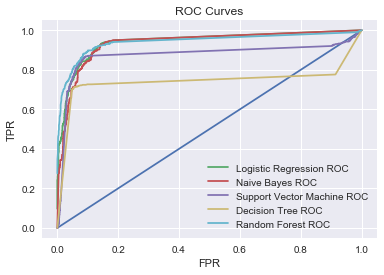

In [28]:
#computing ROC and AUC
lr_fpr, lr_tpr,_ = roc_curve(y1_test, lr1.predict_proba(X1_test)[:,1], pos_label='Yes')
nb_fpr, nb_tpr,_ = roc_curve(y1_test, nb1.predict_proba(X1_test)[:,1], pos_label='Yes')
svm_fpr, svm_tpr,_ = roc_curve(y1_test, svm1.predict_proba(X1_test)[:,1], pos_label='Yes')
dt_fpr, dt_tpr,_ = roc_curve(y1_test, dt1.predict_proba(X1_test)[:,1], pos_label='Yes')
rf_fpr, rf_tpr,_ = roc_curve(y1_test, rf1.predict_proba(X1_test)[:,1], pos_label='Yes')

print('Logistic Regression AUC:',auc(lr_fpr, lr_tpr))
print('Naive Bayes AUC:',auc(nb_fpr, nb_tpr))
print('Support Vector Machine AUC:',auc(svm_fpr, svm_tpr))
print('Decision Tree AUC:',auc(dt_fpr, dt_tpr))
print('Random Forest AUC:',auc(rf_fpr, rf_tpr))

plt.plot([0,1],[0,1])
plt.plot(lr_fpr,lr_tpr, label='Logistic Regression ROC')
plt.plot(nb_fpr,nb_tpr, label='Naive Bayes ROC')
plt.plot(svm_fpr,svm_tpr, label='Support Vector Machine ROC')
plt.plot(dt_fpr,dt_tpr, label='Decision Tree ROC')
plt.plot(rf_fpr,rf_tpr, label='Random Forest ROC')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC Curves')
plt.legend();

In [29]:
# the dumbest reasonable model would be one that predicted No every time. 
len(y1_test[y1_test['Attack'] == 'No'])/len(y1_test)

0.8333333333333334

In [9]:
df_ex = pd.read_excel('data/GemDataEXTR/Exchange rate, old LCU per USD extended forward, period average.xlsx',sheetname=1, index_col=0)
df_ex = df_un.iloc[1:]
df_ex = df_un.ffill()
df_ex = df_un.stack().reset_index()
df_ex['year'] = df_ex['level_0'].map(lambda x: int(x.split('M')[0]))
df_ex['month'] = df_ex['level_0'].map(lambda x: int(x.split('M')[1]))
df_ex.columns = ['index', 'country', 'exchange_rate', 'year', 'month']
df_ex.head()

,index,country,exchange_rate,year,month
0,1990M01,Afghanistan,43.507300,1990,1
1,1990M01,Angola,49.071910,1990,1
2,1990M01,United Arab Emirates,3.675000,1990,1
3,1990M01,Argentina,0.167344,1990,1
4,1990M01,Antigua and Barbuda,2.690000,1990,1


In [74]:
# try replacing nans with rolling mean 12months

In [73]:
df_c2 = pd.merge(df_c, df_ex, on=['country', 'year', 'month'])

# create lags
for n in range(1,13):
    new_column = 'exchange_rate_AR'+str(n)
    df_c2[new_column] = df_c2.groupby(['country'])['exchange_rate'].shift(n)
    df_c2 = df_c2.dropna()
    
#fit models
train_mask2 = ((df_c2['year'] > 2000) &
               (df_c2['year'] < 2016))# focus on after 2000 and exclude test

test_mask2 = (df_c2['year'] == 2016)
            
           
features2 = ['nkill_AR'+str(n) for n in range(1,13)] + ['exchange_rate_AR'+str(n) for n in range(1,13)]

labels2 = ['Attack']

#define X, y, train, and test
X2_train = df_c2[features2][train_mask2]
X2_test = df_c2[features2][test_mask2]
y2_train = df_c2[labels2][train_mask2]
y2_test = df_c2[labels2][test_mask2]

# fit logistic regression
lr2 = LogisticRegression(C=1)
lr2.fit(X2_train, y2_train)
print('Logistic Regression Accuracy:', lr2.score(X2_test, y2_test))
print(classification_report(y2_test, lr2.predict(X2_test)))
print('\n'*1,'='*60,'\n'*2)

# SVM
svm2 = SVC(probability=True)
svm2.fit(X2_train, y2_train)
print('Support Vector Machine Accuracy:', svm2.score(X2_test, y2_test))
print(classification_report(y2_test, svm2.predict(X2_test)))
print('\n'*1,'='*60,'\n'*2)

# Random Forest
rf2 = RandomForestClassifier()
rf2.fit(X2_train, y2_train)
print('Random Forest Accuracy:', rf2.score(X2_test, y2_test))
print(classification_report(y2_test, rf2.predict(X2_test)))

/Users/maliksalam/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy: 0.884920634921
             precision    recall  f1-score   support

         No       0.90      0.96      0.93      1423
        Yes       0.77      0.58      0.66       341

avg / total       0.88      0.88      0.88      1764






/Users/maliksalam/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:42: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Random Forest Accuracy: 0.904195011338
             precision    recall  f1-score   support

         No       0.92      0.97      0.94      1423
        Yes       0.82      0.65      0.72       341

avg / total       0.90      0.90      0.90      1764



Looks like we lose too many rows to NAs to be able to draw meaningful conclusions and cannot do much better than our original model

# Export for Mapping

In [6]:
import pycountry

In [30]:
df_map = df_v[['country', 'Probability of Attack']]
df_map = df_map.replace({'Bolivia': 'Bolivia, Plurinational State of',
                         'Bosnia-Herzegovina':'Bosnia and Herzegovina',
                         'Brunei': 'Brunei Darussalam',
                         'Czech Republic': 'Czechia',
                         'Democratic Republic of the Congo': 'Congo, The Democratic Republic of the',
                         'East Timor': 'Timor-Leste',
                         'Falkland Islands': 'Falkland Islands (Malvinas)',
                         'Iran': 'Iran, Islamic Republic of',
                         'Ivory Coast':"Côte d'Ivoire",
                         'Laos': "Lao People's Democratic Republic",
                         'Macedonia':'Macedonia, Republic of',
                         'Moldova': 'Moldova, Republic of',
                         'North Korea': "Korea, Democratic People's Republic of",
                         "People's Republic of the Congo": 'Congo, The Democratic Republic of the',
                         'Republic of the Congo': 'Congo',
                         'Russia': 'Russian Federation',
                         'Slovak Republic': 'Slovakia',
                         'South Korea': 'Korea, Republic of',
                         'St. Kitts and Nevis': 'Saint Kitts and Nevis',
                         'St. Lucia': 'Saint Lucia',
                         'Syria': 'Syrian Arab Republic',
                         'Taiwan': 'Taiwan, Province of China',
                         'Tanzania': 'Tanzania, United Republic of',
                         'Vatican City': 'Holy See (Vatican City State)',
                         'Venezuela': 'Venezuela, Bolivarian Republic of',
                         'Vietnam': 'Viet Nam',
                         'West Bank and Gaza Strip': 'Palestine, State of'
                         
                        })
df_map = df_map.drop([22128, 25368, 43728, 50208, 56148, 67488, 70188, 77208, 80988, 86928, 87468, 88008, 105288, 106908, 107448 ])
#df_map = df_map.drop([23208, 26448, 44808, 51288, 57228, 68568, 71808, 78828, 82608, 88548, 89088, 89628, 107448, 109068, 109608])

In [31]:
df_map[df_map['country']== 'Zaire']

,country,Probability of Attack


In [32]:
df_map['country_code'] = df_map['country'].apply(lambda x :pycountry.countries.get(name=x).alpha_3)

In [33]:
df_map.to_csv('d3_map/countries_prob.csv')

In [34]:
df_c[(df_c['country']=='United States') & (df_c['year']==2017)]

,country,year,month,nkill,gname,nkill_AR1,nkill_AR2,nkill_AR3,nkill_AR4,nkill_AR5,nkill_AR6,nkill_AR7,nkill_AR8,nkill_AR9,nkill_AR10,nkill_AR11,nkill_AR12,Attack
100968,United States,2017,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,No
100969,United States,2017,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,No
100970,United States,2017,3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,No
100971,United States,2017,4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,No
100972,United States,2017,5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,No
100973,United States,2017,6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,No
100974,United States,2017,7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,No
100975,United States,2017,8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,No
100976,United States,2017,9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,No
100977,United States,2017,10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,No


In [358]:
df_master[(df_master['country_txt']=='United States') & (df_master['iyear']==2016) & (df_master['nkill']>1)][['nkill', 'summary']]

,nkill,summary


In [21]:
# outputting maps with unaffiliated individuals
df_master = pd.read_pickle('GTD_df.p')
df_c = df_master.groupby(['country_txt', 'iyear', 'imonth']).agg({"nkill": 'sum', 'gname': 'nunique'})
#fill holes
new_index = pd.MultiIndex.from_product([df_c.index.get_level_values(0).unique(), np.arange(1973,2018), np.arange(1,13)])
df_c = df_c.reindex(new_index).fillna(0)
df_c = df_c.reset_index()
df_c.rename(columns={'level_0':'country',
                     'level_1': 'year',
                     'level_2': 'month'}, inplace=True)


#create lags
for n in range(1,13):
    new_column = 'nkill_AR'+str(n)
    df_c[new_column] = df_c.groupby(['country'])['nkill'].shift(n)

df_c['Attack'] = np.where(df_c['nkill']>0, 'Yes', 'No')

# First attempt at modeling
train_mask1 = ((df_c['year'] > 2000) &
               (df_c['year'] < 2016))# focus on after 2000 and exclude test

test_mask1 = (df_c['year'] == 2016)
            
           
features1 = ['nkill_AR'+str(n) for n in range(1,13)]

labels1 = ['Attack']

#define X, y, train, and test
X1_train = df_c[features1][train_mask1]
X1_test = df_c[features1][test_mask1]
y1_train = df_c[labels1][train_mask1]
y1_test = df_c[labels1][test_mask1]

# # SVM
# svm1 = SVC(probability=True)
# svm1.fit(X1_train, y1_train)
# print('Support Vector Machine Accuracy:', svm1.score(X1_test, y1_test))
# print(classification_report(y1_test, svm1.predict(X1_test)))

# output January 2017 probabilities
df_v = df_c[(df_c['year']==2017) & (df_c['month']==1)]
df_v['Probability of Attack'] = svm1.predict_proba(df_v[features1])[:,1]

df_map = df_v[['country', 'Probability of Attack']]
df_map = df_map.replace({'Bolivia': 'Bolivia, Plurinational State of',
                         'Bosnia-Herzegovina':'Bosnia and Herzegovina',
                         'Brunei': 'Brunei Darussalam',
                         'Czech Republic': 'Czechia',
                         'Democratic Republic of the Congo': 'Congo, The Democratic Republic of the',
                         'East Timor': 'Timor-Leste',
                         'Falkland Islands': 'Falkland Islands (Malvinas)',
                         'Iran': 'Iran, Islamic Republic of',
                         'Ivory Coast':"Côte d'Ivoire",
                         'Laos': "Lao People's Democratic Republic",
                         'Macedonia':'Macedonia, Republic of',
                         'Moldova': 'Moldova, Republic of',
                         'North Korea': "Korea, Democratic People's Republic of",
                         "People's Republic of the Congo": 'Congo, The Democratic Republic of the',
                         'Republic of the Congo': 'Congo',
                         'Russia': 'Russian Federation',
                         'Slovak Republic': 'Slovakia',
                         'South Korea': 'Korea, Republic of',
                         'St. Kitts and Nevis': 'Saint Kitts and Nevis',
                         'St. Lucia': 'Saint Lucia',
                         'Syria': 'Syrian Arab Republic',
                         'Taiwan': 'Taiwan, Province of China',
                         'Tanzania': 'Tanzania, United Republic of',
                         'Vatican City': 'Holy See (Vatican City State)',
                         'Venezuela': 'Venezuela, Bolivarian Republic of',
                         'Vietnam': 'Viet Nam',
                         'West Bank and Gaza Strip': 'Palestine, State of'
                         
                        })

df_map = df_map.drop([23208, 26448, 44808, 51288, 57228, 68568, 71808, 78828, 82608, 88548, 89088, 89628, 107448, 109068, 109608])

df_map['country_code'] = df_map['country'].apply(lambda x :pycountry.countries.get(name=x).alpha_3)
df_map.to_csv('d3_map_ind/countries_prob.csv')

/Users/maliksalam/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [20]:
#df_map = df_map.drop([23208, 26448, 44808, 51288, 57228, 68568, 71808, 78828, 82608, 88548, 89088, 89628, 107448, 109068, 109608])
df_map[df_map['country']== 'United States']

,country,Probability of Attack,country_code
102588,United States,0.73315,USA


In [16]:
df_c[(df_c['year']==2017) & (df_c['country']=='United States')]

,country,year,month,nkill,gname,nkill_AR1,nkill_AR2,nkill_AR3,nkill_AR4,nkill_AR5,nkill_AR6,nkill_AR7,nkill_AR8,nkill_AR9,nkill_AR10,nkill_AR11,nkill_AR12,Attack
100968,United States,2017,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,No
100969,United States,2017,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,No
100970,United States,2017,3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,No
100971,United States,2017,4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,No
100972,United States,2017,5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,No
100973,United States,2017,6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,No
100974,United States,2017,7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,No
100975,United States,2017,8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,No
100976,United States,2017,9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,No
100977,United States,2017,10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,No
